In [1]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def read_gfa_with_networkx(file_path):
    # Create an empty directed graph (DiGraph)
    G = nx.Graph()

    # Open the GFA file
    with open(file_path, 'r') as gfa_file:
        for line in gfa_file:
            # Ignore empty lines or comment lines (lines starting with '#')
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            
            # Split the line by tab to separate fields
            fields = line.split('\t')

            # Handle different types of lines (S, L, P)
            line_type = fields[0]
            
            if line_type == 'S':
                # Segment line: S <segment_name> <sequence>
                segment_name = int(fields[1])
                sequence = fields[2]
                length = int (fields[3].split(":")[2]) # Length schema: LN:i:<length>
                avg_coverage = float (fields[4].split(":")[2]) # Coverage schema: dp:f:<coverage>

                # Add the segment as a node with sequence as a node attribute
                G.add_node(segment_name, sequence=sequence, length=length, avg_coverage=avg_coverage)
                
            elif line_type == 'L':
                # Link line: L <from_segment> <from_orient> <to_segment> <to_orient> <overlap>
                from_segment = int(fields[1])
                direction = [fields[2], fields[4]]
                to_segment = int(fields[3])
                overlap = fields[5]
                # Add an edge between the two segments with overlap as an edge attribute
                G.add_edge(from_segment, to_segment, overlap=overlap, direction=direction)

            elif line_type == 'P':
                # Path line: P <path_name> <segments> <overlaps>
                # You can process path information here if needed
                pass

    return G


In [3]:
def save_network_as_gfa(G, output_file_path):
    with open(output_file_path, 'w') as output_file:
        # Write the header
        output_file.write('H\tVN:Z:1.0\n')

        # Write the segment lines
        for node in G.nodes:
            segment_name = node
            sequence = G.nodes[node]['sequence']
            length = G.nodes[node]['length']
            avg_coverage = G.nodes[node]['avg_coverage']
            output_file.write(f'S\t{segment_name}\t{sequence}\tLN:i:{length}\tdp:f:{avg_coverage}\n')

        # Write the link lines
        for edge in G.edges:
            from_segment = edge[0]
            to_segment = edge[1]
            overlap = G.edges[edge]['overlap']
            direction = G.edges[edge]['direction']
            output_file.write(f'L\t{from_segment}\t{direction[0]}\t{to_segment}\t{direction[1]}\t{overlap}\n')

In [4]:
# Example usage
genome_path = './Genome/ecol-SAMN31390129'

gfa_path = genome_path + '/short.gfa'
csv_path = genome_path + '/short.gfa.csv'

splited_gfa_path = genome_path + '/splited/'

if not os.path.exists(splited_gfa_path):
    os.makedirs(splited_gfa_path)

G = read_gfa_with_networkx(gfa_path)

In [5]:
# Just for Testing

# Print nodes and edges
print("Nodes in the graph:")
for node, data in G.nodes(data=True):
    print(f"Node: {node}, Sequence: {data['sequence']}")

print("\nEdges in the graph:")
for from_node, to_node, data in G.edges(data=True):
    print(f"Edge from {from_node} to {to_node}, Overlap: {data['overlap']}")


Nodes in the graph:
Node: 1, Sequence: GTTAATGGATAAATCCATCAACTTATGGACATTTTCGTCGTCCCAGGTCTGGCAGAAAGTGGCCAGGTTCTGACGAGCGTTGCCATCAAGATATAATTCGTCATTGATAATCTGGAATGCGACATCATCACGCATTTCGTGCAGCGGAAAACGTTTTGATTCTGCGATAGTGGAAATAGACTTCGCACCAAAACGTGAATCGAGTAGTTCCGACCTTAAATCCGTTACTTGCTTCTTATCCATTTTAAACTCCTTAAAATGATTGGATCGCATTAAAAAAGTAGGATTTATCGATAAAGTAAGCAAGTGCAAAGGACTCGGTTTTAAATAACAAAATCCTAATGTTATTTATCGCGAGATATTGCGTGAATAATGTATTTTTATTAAAAAACAACATAATAGAGAATTCTGTGTGGAGGTAAGGTGTTTTATGCTGTTATTTTATGTGTTTTCTATCGTCTCCTGAATTATCACGTAAAAATCAGACCTTATAATATCATTATTGGTACACGGTTATTTACTTTGAACACATTTATAAAATTATTACATAAAAATAGCGAATATTGATGAAATCCCCGCCAACGATGTGTTGACGGGGCTGTGATTATTTTGGCAATAATACTCCGGTATAGGTATTCACCGGATGAGAAAGATATTGTTTAACAGCAGTGTTAACATTCTCTACCGTCATTTGTTTCAACAATTGCTCCTGCTCAGTCCATGCTGCAGGATCGTCATATTGAATAAGACTATTTACAATGGTGTTCGCTAATTGTTGAACGCTACGCTGTTGGATATCGAGGCTGCGCTGAACGTTTTGCTGGTATTCGTTCAGTTCTTGCTCACTGATCCCTTTGGCCAGACGCTTAACCATCACTTCATTCGCTAACGTTAACAGTTCATCATGTCGTTCTGGTTGACAAGTAAAAGCCAGCAAATGACTGATATCTTTGGCCTGAGG

In [6]:
short_gfa_df = pd.read_csv(csv_path)

def add_attributes_from_csv(G, csv_df):
    # Iterate over the DataFrame and update the graph nodes with the attributes
    for index, row in csv_df.iterrows():
        node_name = row['contig']
        attribute_value = row['label']
        
        if node_name in G.nodes:
            G.nodes[node_name]['label'] = attribute_value  # Add the attribute to the node

# Add the attributes to the graph
add_attributes_from_csv(G, short_gfa_df)

In [7]:
chromosome_df = short_gfa_df[short_gfa_df['label'] == 'chromosome']
plasmid_df = short_gfa_df[short_gfa_df['label'] == 'plasmid']
ambiguous_df = short_gfa_df[short_gfa_df['label'] == 'ambiguous']
unlabelled_df = short_gfa_df[short_gfa_df['label'] == 'unlabeled']

# Print the number of nodes with each label
print(f"Number of nodes with label 'chromosome': {len(chromosome_df)}")
print(f"Number of nodes with label 'plasmid': {len(plasmid_df)}")
print(f"Number of nodes with label 'ambiguous': {len(ambiguous_df)}")
print(f"Number of nodes with label 'unlabeled': {len(unlabelled_df)}")

Number of nodes with label 'chromosome': 178
Number of nodes with label 'plasmid': 69
Number of nodes with label 'ambiguous': 44
Number of nodes with label 'unlabeled': 95


In [8]:
def nodes_color_map(graph): 

    # Define base colors for types
    base_colors = {
    "chromosome": (1.0, 0.0, 0.0),  # Red
    "plasmid": (0.0, 0.0, 1.0),  # Blue
    "unlabeled": (0.0, 1.0, 0.0),  # Green
    "ambiguous": (1.0, 1.0, 0.0),  # Yellow
    }

    # Generate colors for nodes
    node_colors = []
    for node, data in graph.nodes(data=True):
        
        # Get base color for type
        base_color = base_colors[data['label']]

        length = data['length']

        # Adjust intensity based on length
        if length > 1000:
            intensity = 1.0  # Full intensity
        elif 100 <= length <= 1000:
            intensity = 1  # Medium intensity
        else:
            intensity = 1  # Light intensity

        # Scale the base color
        scaled_color = tuple(intensity * x for x in base_color)
        node_colors.append(scaled_color)

    return node_colors

317 317


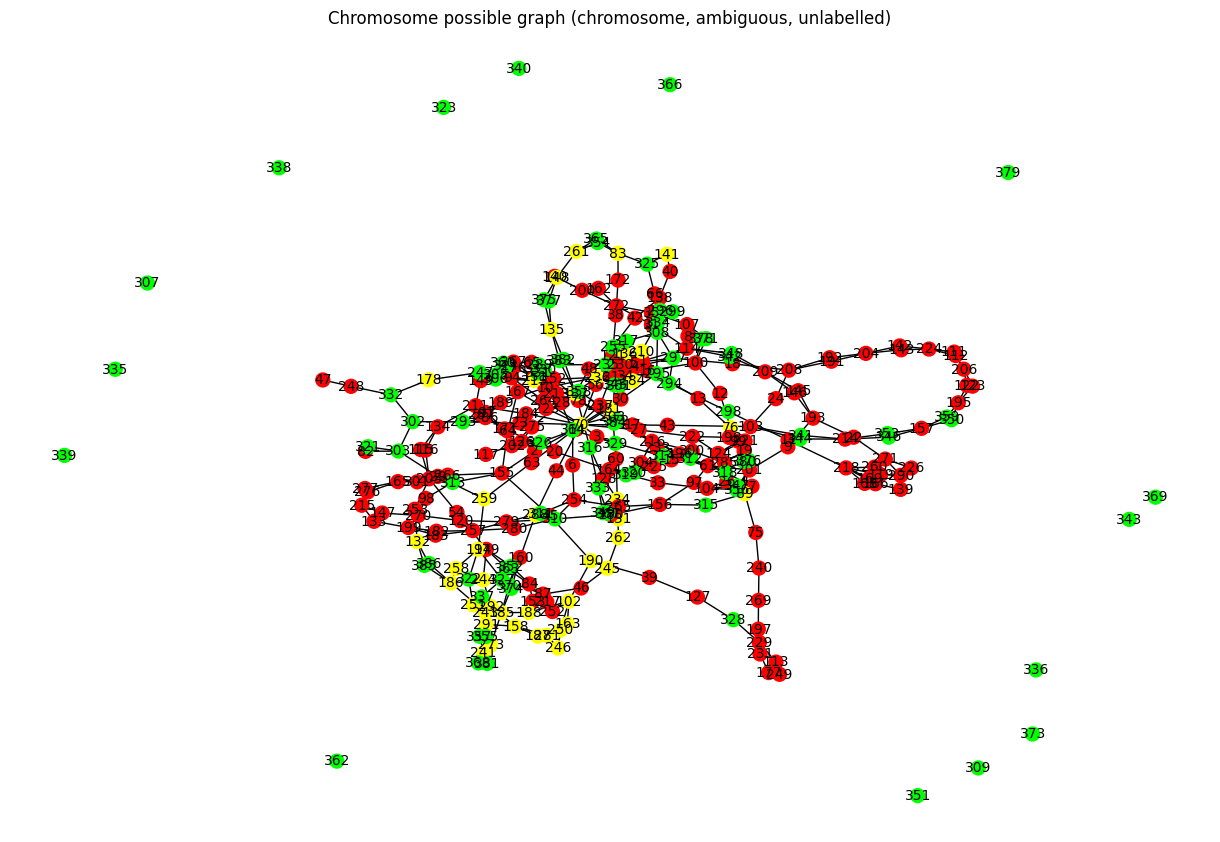

In [ ]:
# Draw the chromosome subgraph
chromosome_nodes = chromosome_df['contig'].tolist()
ambiguous_nodes = ambiguous_df['contig'].tolist()
unlabelled_nodes = unlabelled_df['contig'].tolist()

chromosome_possible_nodes = chromosome_nodes + ambiguous_nodes + unlabelled_nodes

chromosome_possible_subgraph = G.subgraph(chromosome_possible_nodes)


node_colors = nodes_color_map(chromosome_possible_subgraph)

save_network_as_gfa(chromosome_possible_subgraph, splited_gfa_path + 'chromosome_possible.gfa')

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(chromosome_possible_subgraph)
nx.draw(chromosome_possible_subgraph, pos, with_labels=True, node_size=100, node_color=node_colors, font_size=10)
plt.title('Chromosome possible graph (chromosome, ambiguous, unlabelled)')
plt.show()

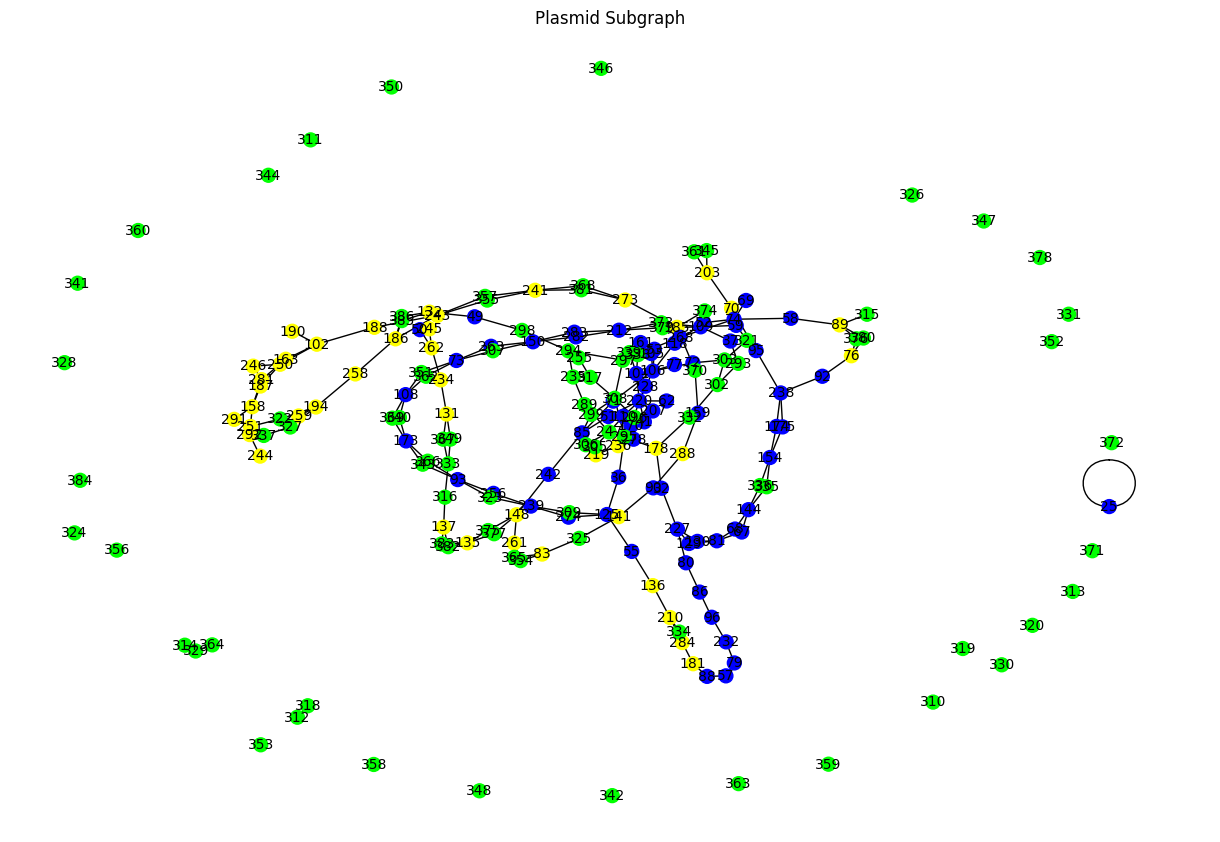

In [12]:
# Draw the plasmid subgraph
plasmid_nodes = plasmid_df['contig'].tolist()
ambiguous_nodes = ambiguous_df['contig'].tolist()
unlabelled_nodes = unlabelled_df['contig'].tolist()

plasmid_possible_nodes = plasmid_nodes + ambiguous_nodes + unlabelled_nodes

plasmid_possible_subgraph = G.subgraph(plasmid_possible_nodes)

node_colors = nodes_color_map(plasmid_possible_subgraph)

save_network_as_gfa(plasmid_possible_subgraph, splited_gfa_path + 'plasmid_possible.gfa')

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(plasmid_possible_subgraph)
nx.draw(plasmid_possible_subgraph, pos, with_labels=True, node_size=100, node_color=node_colors, font_size=10)
plt.title('Plasmid Subgraph')
plt.show()


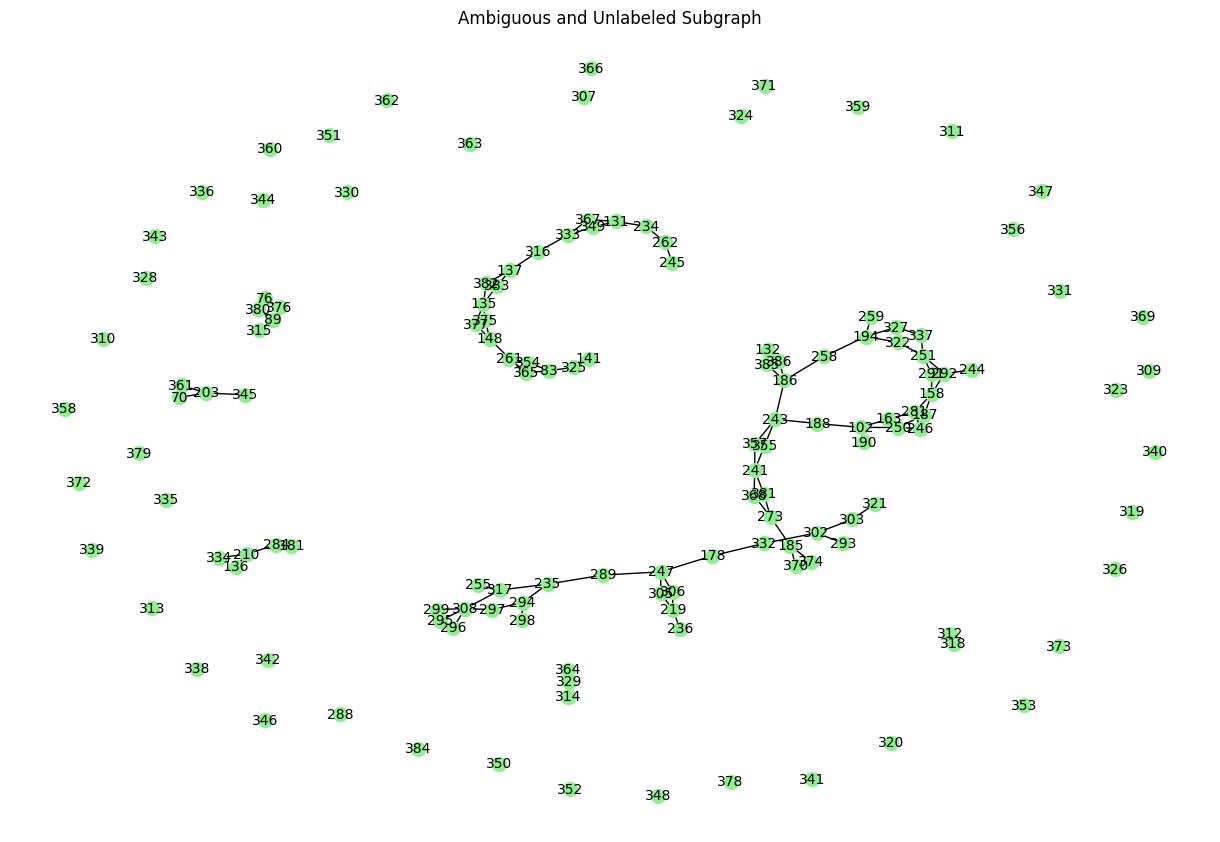

In [98]:
# Draw the ambiguous and unlabeled subgraph

ambiguous_nodes = ambiguous_df['contig'].tolist()
unlabelled_nodes = unlabelled_df['contig'].tolist()

ambiguous_unlabelled_nodes = ambiguous_nodes + unlabelled_nodes

ambiguous_unlabelled_subgraph = G.subgraph(ambiguous_unlabelled_nodes)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(ambiguous_unlabelled_subgraph)
nx.draw(ambiguous_unlabelled_subgraph, pos, with_labels=True, node_size=100, node_color='lightgreen', font_size=10)
plt.title('Ambiguous and Unlabeled Subgraph')
plt.show()

In [99]:
for cycle in nx.simple_cycles(plasmid_subgraph):
    print("Cycle:", cycle)


Cycle: [25]
Cycle: [154, 174, 238, 175]
Cycle: [71, 106, 220, 51, 85]
Cycle: [220, 101, 228]
Cycle: [161, 53, 106, 105]
Cycle: [282, 150, 283, 212]
Cycle: [81, 129, 227, 130]
Cycle: [144, 68, 81, 67]


In [132]:
def find_nearest_label(G, start_node, target_label):
    # Find all nodes with the target label
    nodes_with_label = [node for node, data in G.nodes(data=True) if data.get('label') == target_label]

    # If start node has the target label, exlude it from the list
    if start_node in nodes_with_label:
        nodes_with_label.remove(start_node)

    # Use BFS to find the shortest path to the nearest node with the target label
    shortest_distance = float('inf')
    nearest_node = None

    for node in nodes_with_label:
        try:
            distance = nx.shortest_path_length(G, source=start_node, target=node)
            if distance < shortest_distance:
                shortest_distance = distance
                nearest_node = node
        except nx.NetworkXNoPath:
            continue  # Skip nodes that are not reachable

    return nearest_node, shortest_distance

In [ ]:
# Find the nearest 'chromosome' node from the 'plasmid' nodes and average distance
total_distance = 0

for plasmid_node in plasmid_nodes:
    nearest_chromosome, distance = find_nearest_label(G, plasmid_node, 'chromosome')
    print(f"Nearest chromosome node to {plasmid_node}: {nearest_chromosome}, Distance: {distance}")
    total_distance += distance

pls_chr_average_distance = total_distance / len(plasmid_nodes)

Nearest chromosome node to 25: None, Distance: inf
Nearest chromosome node to 32: 248, Distance: 3
Nearest chromosome node to 36: 13, Distance: 2
Nearest chromosome node to 37: 23, Distance: 2
Nearest chromosome node to 41: 13, Distance: 2
Nearest chromosome node to 49: 11, Distance: 2
Nearest chromosome node to 50: 46, Distance: 2
Nearest chromosome node to 51: 1, Distance: 4
Nearest chromosome node to 52: 3, Distance: 4
Nearest chromosome node to 53: 29, Distance: 4
Nearest chromosome node to 55: 21, Distance: 2
Nearest chromosome node to 57: 14, Distance: 3
Nearest chromosome node to 58: 7, Distance: 2
Nearest chromosome node to 59: 82, Distance: 2
Nearest chromosome node to 62: 1, Distance: 4
Nearest chromosome node to 67: 248, Distance: 7
Nearest chromosome node to 68: 248, Distance: 7
Nearest chromosome node to 69: 3, Distance: 2
Nearest chromosome node to 71: 29, Distance: 4
Nearest chromosome node to 72: 29, Distance: 2
Nearest chromosome node to 73: 23, Distance: 9
Nearest chr

In [ ]:
# Find the nearest 'chromosome' node from the 'chromosome' nodes and the average distance
total_distance = 0

for chromosome_node in chromosome_nodes:
    nearest_plasmid, distance = find_nearest_label(G, chromosome_node, 'chromosome')
    print(f"Nearest chromosome node to {chromosome_node}: {nearest_plasmid}, Distance: {distance}")
    total_distance += distance

chr_chr_average_distance = total_distance / len(chromosome_nodes)

Nearest chromosome node to 1: 114, Distance: 1
Nearest chromosome node to 2: 155, Distance: 1
Nearest chromosome node to 3: 23, Distance: 2
Nearest chromosome node to 4: 1, Distance: 2
Nearest chromosome node to 5: 1, Distance: 2
Nearest chromosome node to 6: 254, Distance: 1
Nearest chromosome node to 7: 75, Distance: 2
Nearest chromosome node to 8: 107, Distance: 1
Nearest chromosome node to 9: 193, Distance: 1
Nearest chromosome node to 10: 189, Distance: 1
Nearest chromosome node to 11: 218, Distance: 1
Nearest chromosome node to 12: 100, Distance: 1
Nearest chromosome node to 13: 12, Distance: 2
Nearest chromosome node to 14: 126, Distance: 2
Nearest chromosome node to 15: 233, Distance: 1
Nearest chromosome node to 16: 100, Distance: 1
Nearest chromosome node to 17: 233, Distance: 1
Nearest chromosome node to 18: 208, Distance: 1
Nearest chromosome node to 19: 198, Distance: 1
Nearest chromosome node to 20: 164, Distance: 1
Nearest chromosome node to 21: 237, Distance: 1
Nearest 

In [ ]:
# Find the nearest 'plasmid' node from the 'chromosome' nodes and the average distance
total_distance = 0

for chromosome_node in chromosome_nodes:
    nearest_plasmid, distance = find_nearest_label(G, chromosome_node, 'plasmid')
    print(f"Nearest plasmid node to {chromosome_node}: {nearest_plasmid}, Distance: {distance}")
    total_distance += distance

average_distance = total_distance / len(chromosome_nodes)

Nearest plasmid node to 1: 170, Distance: 2
Nearest plasmid node to 2: 55, Distance: 5
Nearest plasmid node to 3: 69, Distance: 2
Nearest plasmid node to 4: 170, Distance: 2
Nearest plasmid node to 5: 170, Distance: 2
Nearest plasmid node to 6: 55, Distance: 5
Nearest plasmid node to 7: 58, Distance: 2
Nearest plasmid node to 8: 268, Distance: 2
Nearest plasmid node to 9: 69, Distance: 7
Nearest plasmid node to 10: 170, Distance: 2
Nearest plasmid node to 11: 49, Distance: 2
Nearest plasmid node to 12: 92, Distance: 2
Nearest plasmid node to 13: 36, Distance: 2
Nearest plasmid node to 14: 88, Distance: 2
Nearest plasmid node to 15: 69, Distance: 5
Nearest plasmid node to 16: 170, Distance: 2
Nearest plasmid node to 17: 55, Distance: 4
Nearest plasmid node to 18: 268, Distance: 2
Nearest plasmid node to 19: 58, Distance: 5
Nearest plasmid node to 20: 170, Distance: 6
Nearest plasmid node to 21: 55, Distance: 2
Nearest plasmid node to 22: 49, Distance: 6
Nearest plasmid node to 23: 37, D

In [137]:
# Print the average distances

print(f"Average distance from plasmid to chromosome: {average_distance}")
print(f"Average distance from chromosome to chromosome: {average_distance}")
print(f"Average distance from chromosome to plasmid: {average_distance}")

Average distance from plasmid to chromosome: inf
Average distance from chromosome to chromosome: inf
Average distance from chromosome to plasmid: inf
